In [28]:
# lancer le notebook collect_articles.ipynb pour collecter les articles avant de lancer celui-ci

# Auto-reload pour développement interactif
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
import json
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import defaultdict

# Configuration
base_dir = Path().resolve().parent.parent
sys.path.append(str(base_dir / "src"))

# Répertoires
outputs_dir = base_dir / "outputs"
data_dir = base_dir / "data"
exports_dir = data_dir / "exports"
exports_dir.mkdir(parents=True, exist_ok=True)

from config.database import engine, SessionLocal
from data.models import Base
from data.database_manager import DatabaseManager
from features.enricher import ArticleEnricher



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:

print("ÉTAPE 1: Chargement du JSON de collecte")

# Configuration
MAX_ARTICLES = 200  # Limite pour éviter les runs trop longs
MIN_TEXT_LENGTH = 200  # Seuil minimum pour enrichissement

# Recherche exhaustive de tous les fichiers JSON potentiels
search_locations = [
    base_dir / "data" / "exports",
    base_dir / "outputs", 
    base_dir / "data",
    base_dir,
    Path().resolve()  # Répertoire courant du notebook
]






ÉTAPE 1: Chargement du JSON de collecte


In [30]:
print("EXPLORATION DES RÉPERTOIRES:")

all_json_files = []

for location in search_locations:
    print(f"\n{location}")
    
    if location.exists():
        # Rechercher tous les fichiers JSON
        json_files = list(location.glob("*.json"))
        
        if json_files:
            print(f"   Répertoire existe | {len(json_files)} fichiers JSON trouvés:")
            for json_file in json_files:
                file_time = datetime.fromtimestamp(json_file.stat().st_mtime)
                file_age_hours = (datetime.now() - file_time).total_seconds() / 3600
                file_size_kb = json_file.stat().st_size / 1024
                
                print(f"      {json_file.name}")
                print(f"         {file_time.strftime('%Y-%m-%d %H:%M')}")
                print(f"         {file_age_hours:.1f}h | {file_size_kb:.1f}KB")
                
                all_json_files.append({
                    'path': json_file,
                    'name': json_file.name,
                    'time': file_time,
                    'age_hours': file_age_hours,
                    'size_kb': file_size_kb
                })
        else:
            print(f"   Répertoire existe | Aucun fichier JSON")
    else:
        print(f"   Répertoire n'existe pas")

# Utilisation de la liste des fichiers JSON trouvés
if not all_json_files:
    print("AUCUN FICHIER JSON TROUVÉ")
    print("Solutions:")
    print("   1. Exécutez d'abord le notebook de collecte")
    print("   2. Vérifiez que la collecte génère un fichier JSON")
    exit(1)







EXPLORATION DES RÉPERTOIRES:

C:\Users\beedi.goua_square-ma\Desktop\Gheb\projet perso\InsightDetector\insight-detector\data\exports
   Répertoire existe | 1 fichiers JSON trouvés:
      raw_articles.json
         2025-07-26 08:23
         1.1h | 2550.9KB

C:\Users\beedi.goua_square-ma\Desktop\Gheb\projet perso\InsightDetector\insight-detector\outputs
   Répertoire existe | Aucun fichier JSON

C:\Users\beedi.goua_square-ma\Desktop\Gheb\projet perso\InsightDetector\insight-detector\data
   Répertoire existe | Aucun fichier JSON

C:\Users\beedi.goua_square-ma\Desktop\Gheb\projet perso\InsightDetector\insight-detector
   Répertoire existe | Aucun fichier JSON

C:\Users\beedi.goua_square-ma\Desktop\Gheb\projet perso\InsightDetector\insight-detector\notebooks\02_semantic_enrichment
   Répertoire existe | Aucun fichier JSON


In [31]:
# Tri par âge (plus récent en premier) et taille (plus gros en premier)
recent_files = [f for f in all_json_files if f['age_hours'] < 48]  # Moins de 48h

if not recent_files:
    print("Aucun fichier JSON récent (< 48h), utilisation du plus récent disponible")
    recent_files = sorted(all_json_files, key=lambda x: x['time'], reverse=True)[:3]

# Sélection du meilleur candidat
def score_file(file_info):
    """Score un fichier JSON selon plusieurs critères"""
    score = 0
    name = file_info['name'].lower()
    
    # Bonus pour noms pertinents
    if 'article' in name:
        score += 100
    if 'collect' in name or 'raw' in name:
        score += 50
    if 'enriched' in name:
        score -= 50  # Éviter les fichiers déjà enrichis
    
    # Bonus pour récence (inversement proportionnel à l'âge)
    score += max(0, 48 - file_info['age_hours'])
    
    # Bonus pour taille (fichiers plus gros = plus d'articles)
    score += min(file_info['size_kb'] / 100, 50)  # Cap à 50 points
    
    return score

# Tri par score
scored_files = [(f, score_file(f)) for f in recent_files]
scored_files.sort(key=lambda x: x[1], reverse=True)

print(f"\nANALYSE DES CANDIDATS:")
for i, (file_info, score) in enumerate(scored_files[:5], 1):
    print(f"   {i}. {file_info['name']} (score: {score:.1f})")
    print(f"      {file_info['time'].strftime('%Y-%m-%d %H:%M')} | {file_info['age_hours']:.1f}h | {file_info['size_kb']:.1f}KB")

# Sélection du meilleur fichier
best_file_info = scored_files[0][0]
latest_file = best_file_info['path']
latest_time = best_file_info['time']

print(f"\nFICHIER SÉLECTIONNÉ: {latest_file.name}")
print(f"   Chemin: {latest_file}")
print(f"   Modifié: {latest_time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"   Âge: {best_file_info['age_hours']:.1f} heures")
print(f"   Taille: {best_file_info['size_kb']:.1f} KB")



ANALYSE DES CANDIDATS:
   1. raw_articles.json (score: 222.4)
      2025-07-26 08:23 | 1.1h | 2550.9KB

FICHIER SÉLECTIONNÉ: raw_articles.json
   Chemin: C:\Users\beedi.goua_square-ma\Desktop\Gheb\projet perso\InsightDetector\insight-detector\data\exports\raw_articles.json
   Modifié: 2025-07-26 08:23:31
   Âge: 1.1 heures
   Taille: 2550.9 KB


In [32]:
# Vérification rapide du contenu
try:
    # Test de lecture pour vérifier la validité
    with open(latest_file, 'r', encoding='utf-8') as f:
        # Lire juste le début pour validation
        content_preview = f.read(1000)
        if not content_preview.strip().startswith('['):
            print("Attention: Le fichier ne semble pas être une liste JSON")
    
    print("Fichier JSON valide détecté")
    
except Exception as e:
    print(f"Erreur validation fichier: {e}")
    # Essayer le fichier suivant
    if len(scored_files) > 1:
        print("Essai du fichier suivant...")
        best_file_info = scored_files[1][0]
        latest_file = best_file_info['path']
        latest_time = best_file_info['time']
        print(f"Fichier alternatif: {latest_file.name}")
    else:
        exit(1)




Fichier JSON valide détecté


In [33]:
# Chargement du JSON
print(f"\nCHARGEMENT: {latest_file.name}")
try:
    with open(latest_file, 'r', encoding='utf-8') as f:
        raw_articles = json.load(f)
    
    print(f"Articles chargés: {len(raw_articles)}")
    file_age = (datetime.now() - latest_time).total_seconds() / 3600
    print(f"Âge du fichier: {file_age:.1f} heures")
    
except Exception as e:
    print(f"Erreur chargement: {e}")
    exit(1)


CHARGEMENT: raw_articles.json
Articles chargés: 586
Âge du fichier: 1.1 heures


In [34]:

# ÉTAPE 2: ANALYSE ET FILTRAGE DES ARTICLES

# Analyse des articles
analysis = {
    "total": len(raw_articles),
    "with_text": 0,
    "sufficient_text": 0,
    "with_summary_only": 0,
    "empty_content": 0,
    "candidates": []
}

print("Analyse du contenu:")

for article in raw_articles:
    text = article.get('text', '')
    summary = article.get('summary', '')
    
    text_length = len(text) if text else 0
    summary_length = len(summary) if summary else 0
    total_content_length = text_length + summary_length
    
    # Catégorisation
    if text_length >= MIN_TEXT_LENGTH:
        analysis["with_text"] += 1
        analysis["sufficient_text"] += 1
        analysis["candidates"].append(article)
    elif text_length > 0 or summary_length >= 100:
        analysis["with_summary_only"] += 1
        # Inclure aussi les articles avec résumé substantiel
        if total_content_length >= MIN_TEXT_LENGTH:
            analysis["candidates"].append(article)
    else:
        analysis["empty_content"] += 1



Analyse du contenu:


In [35]:
print(f"   Total articles: {analysis['total']}")
print(f"   Avec texte complet (≥{MIN_TEXT_LENGTH}): {analysis['sufficient_text']}")
print(f"   Avec résumé seulement: {analysis['with_summary_only']}")
print(f"   Contenu insuffisant: {analysis['empty_content']}")
print(f"   Candidats à enrichir: {len(analysis['candidates'])}")



   Total articles: 586
   Avec texte complet (≥200): 542
   Avec résumé seulement: 42
   Contenu insuffisant: 2
   Candidats à enrichir: 580


In [36]:
# Sélection finale et tri
articles_to_enrich = analysis["candidates"]

if not articles_to_enrich:
    print("AUCUN ARTICLE CANDIDAT")
    print("Solutions:")
    print(f"   - Réduire MIN_TEXT_LENGTH (actuellement {MIN_TEXT_LENGTH})")
    print("   - Vérifier que la collecte a récupéré le contenu complet")
    exit(1)

# Tri par qualité du contenu (texte le plus long en premier)
articles_to_enrich.sort(
    key=lambda x: len(x.get('text', '') + x.get('summary', '')), 
    reverse=True
)

# Limitation pour éviter les runs trop longs
if len(articles_to_enrich) > MAX_ARTICLES:
    print(f"Limitation: {len(articles_to_enrich)} → {MAX_ARTICLES} articles")
    articles_to_enrich = articles_to_enrich[:MAX_ARTICLES]

print(f"\nARTICLES SÉLECTIONNÉS POUR ENRICHISSEMENT: {len(articles_to_enrich)}")

Limitation: 580 → 200 articles

ARTICLES SÉLECTIONNÉS POUR ENRICHISSEMENT: 200


In [37]:


# Aperçu des articles sélectionnés
print(f"\nAPERÇU (5 premiers):")
for i, article in enumerate(articles_to_enrich[:5], 1):
    title = article['title'][:50] + "..." if len(article['title']) > 50 else article['title']
    text_len = len(article.get('text', ''))
    summary_len = len(article.get('summary', ''))
    source_name = article.get('source', '').split('/')[-1] if article.get('source') else 'N/A'
    
    print(f"   {i}. {title}")
    print(f"      {source_name} | {text_len}+{summary_len} chars")





APERÇU (5 premiers):
   1. Top 10 AI Content Generator & Writer Tools in 2022
       | 18555+18203 chars
   2. How I Fine-Tuned Granite-Vision 2B to Beat a 90B M...
      feed | 35793+233 chars
   3. When LLMs Try to Reason: Experiments in Text and V...
      feed | 31948+723 chars
   4. "On n'a fait que du Tetris" : on vous raconte l'hi...
      titres.rss | 31889+258 chars
   5. How Not to Mislead with Your Data-Driven Story
      feed | 27673+575 chars


In [38]:
# ÉTAPE 3: ENRICHISSEMENT IA

# Estimation du temps
estimated_time_per_article = 20  # secondes
total_time = len(articles_to_enrich) * estimated_time_per_article
print(f"Estimation: {len(articles_to_enrich)} articles × {estimated_time_per_article}s = {total_time//60}m {total_time%60}s")

# Initialisation de l'enricher
try:
    enricher = ArticleEnricher()
    print("ArticleEnricher initialisé")
except Exception as e:
    print(f"Erreur initialisation enricher: {e}")
    exit(1)


Estimation: 200 articles × 20s = 66m 40s
ArticleEnricher initialisé


In [39]:
# Enrichissement avec suivi détaillé
enriched_articles = []
enrichment_stats = {
    "success": 0,
    "partial": 0,
    "failed": 0,
    "start_time": datetime.now()
}


In [40]:
print(f"\nEnrichissement en cours...")

for i, article in enumerate(tqdm(articles_to_enrich, desc="Enrichissement"), 1):
    try:
        # Affichage du progrès
        if i % 10 == 1:  # Afficher chaque 10 articles
            elapsed = (datetime.now() - enrichment_stats["start_time"]).total_seconds()
            remaining = (elapsed / i) * (len(articles_to_enrich) - i)
            print(f"\nProgrès: {i}/{len(articles_to_enrich)} | Restant: ~{remaining//60:.0f}m")
        
        # Enrichissement de l'article
        enriched_article = enricher.enrich(article)
        
        # Vérification de la qualité de l'enrichissement
        enrichment_quality = sum([
            bool(enriched_article.get('quality_score')),
            bool(enriched_article.get('language')),
            bool(enriched_article.get('entities')),
            bool(enriched_article.get('embedding'))
        ])
        
        if enrichment_quality >= 3:
            enrichment_stats["success"] += 1
        elif enrichment_quality >= 1:
            enrichment_stats["partial"] += 1
        else:
            enrichment_stats["failed"] += 1
        
        enriched_articles.append(enriched_article)
        
    except Exception as e:
        print(f"\nErreur article {i}: {e}")
        # Garder l'article original en cas d'échec
        enriched_articles.append(article)
        enrichment_stats["failed"] += 1


Enrichissement en cours...


Enrichissement:   0%|          | 0/200 [00:00<?, ?it/s]


Progrès: 1/200 | Restant: ~2m


Enrichissement:   5%|▌         | 10/200 [00:32<04:55,  1.56s/it]


Progrès: 11/200 | Restant: ~9m


Enrichissement:  10%|█         | 20/200 [00:42<02:50,  1.06it/s]


Progrès: 21/200 | Restant: ~6m


Enrichissement:  15%|█▌        | 30/200 [00:52<02:59,  1.06s/it]


Progrès: 31/200 | Restant: ~4m


Enrichissement:  20%|██        | 40/200 [00:59<01:32,  1.72it/s]


Progrès: 41/200 | Restant: ~3m


Enrichissement:  25%|██▌       | 50/200 [01:06<01:51,  1.35it/s]


Progrès: 51/200 | Restant: ~3m


Enrichissement:  30%|███       | 60/200 [01:12<01:21,  1.73it/s]


Progrès: 61/200 | Restant: ~2m


Enrichissement:  35%|███▌      | 70/200 [01:19<01:27,  1.49it/s]


Progrès: 71/200 | Restant: ~2m


Enrichissement:  40%|████      | 80/200 [01:24<00:53,  2.26it/s]


Progrès: 81/200 | Restant: ~2m


Enrichissement:  45%|████▌     | 90/200 [01:29<00:54,  2.01it/s]


Progrès: 91/200 | Restant: ~1m


Enrichissement:  50%|█████     | 100/200 [01:33<00:50,  1.98it/s]


Progrès: 101/200 | Restant: ~1m


Enrichissement:  55%|█████▌    | 110/200 [01:38<00:38,  2.32it/s]


Progrès: 111/200 | Restant: ~1m


Enrichissement:  60%|██████    | 120/200 [01:43<00:35,  2.28it/s]


Progrès: 121/200 | Restant: ~1m


Enrichissement:  65%|██████▌   | 130/200 [01:48<00:29,  2.38it/s]


Progrès: 131/200 | Restant: ~0m


Enrichissement:  70%|███████   | 140/200 [01:52<00:24,  2.44it/s]


Progrès: 141/200 | Restant: ~0m


Enrichissement:  75%|███████▌  | 150/200 [01:58<00:32,  1.53it/s]


Progrès: 151/200 | Restant: ~0m


Enrichissement:  80%|████████  | 160/200 [02:02<00:15,  2.58it/s]


Progrès: 161/200 | Restant: ~0m


Enrichissement:  85%|████████▌ | 170/200 [02:07<00:13,  2.20it/s]


Progrès: 171/200 | Restant: ~0m


Enrichissement:  90%|█████████ | 180/200 [02:10<00:08,  2.43it/s]


Progrès: 181/200 | Restant: ~0m


Enrichissement:  95%|█████████▌| 190/200 [02:14<00:03,  2.84it/s]


Progrès: 191/200 | Restant: ~0m


Enrichissement: 100%|██████████| 200/200 [02:18<00:00,  1.44it/s]


In [41]:
# Statistiques d'enrichissement
enrichment_stats["end_time"] = datetime.now()
total_duration = (enrichment_stats["end_time"] - enrichment_stats["start_time"]).total_seconds()

print(f"\nSTATISTIQUES D'ENRICHISSEMENT:")
print(f"   Succès complets: {enrichment_stats['success']}")
print(f"   Succès partiels: {enrichment_stats['partial']}")
print(f"   Échecs: {enrichment_stats['failed']}")
print(f"   Durée totale: {total_duration//60:.0f}m {total_duration%60:.0f}s")
print(f"   Moyenne: {total_duration/len(articles_to_enrich):.1f}s/article")




STATISTIQUES D'ENRICHISSEMENT:
   Succès complets: 200
   Succès partiels: 0
   Échecs: 0
   Durée totale: 2m 21s
   Moyenne: 0.7s/article


In [42]:
# ÉTAPE 4: SAUVEGARDE EN BASE DE DONNÉES

# Initialisation BDD
Base.metadata.create_all(bind=engine)
session = SessionLocal()
db = DatabaseManager(session=session)

print("Base de données initialisée")

# Sauvegarde des articles enrichis
save_stats = {
    "saved": 0,
    "duplicates": 0,
    "errors": 0
}

print(f"Sauvegarde de {len(enriched_articles)} articles enrichis...")




Base de données initialisée
Sauvegarde de 200 articles enrichis...


In [43]:

for i, article in enumerate(tqdm(enriched_articles, desc="Sauvegarde"), 1):
    try:
        article_id = db.create_article(article)
        
        if article_id:
            save_stats["saved"] += 1
        else:
            save_stats["duplicates"] += 1
            
    except Exception as e:
        print(f"\nErreur sauvegarde article {i}: {e}")
        save_stats["errors"] += 1


Sauvegarde: 100%|██████████| 200/200 [00:00<00:00, 1103.76it/s]


In [44]:
print(f"\nSTATISTIQUES DE SAUVEGARDE:")
print(f"   Articles sauvés: {save_stats['saved']}")
print(f"   Doublons ignorés: {save_stats['duplicates']}")
print(f"   Erreurs: {save_stats['errors']}")




STATISTIQUES DE SAUVEGARDE:
   Articles sauvés: 200
   Doublons ignorés: 0
   Erreurs: 0


In [45]:
#  ÉTAPE 5: EXPORT DES ARTICLES ENRICHIS


# Export JSON complet
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
enriched_file = exports_dir / f"enriched_articles.json"

try:
    with open(enriched_file, 'w', encoding='utf-8') as f:
        json.dump(enriched_articles, f, ensure_ascii=False, indent=2)
    
    print(f"Export JSON: {enriched_file.name}")
    
except Exception as e:
    print(f"Erreur export: {e}")

# Export version légère (sans embeddings)
light_articles = []
for article in enriched_articles:
    light_article = {
        "id": article.get("id"),
        "title": article.get("title"),
        "summary": article.get("summary"),
        "published": article.get("published"),
        "source": article.get("source"),
        "url": article.get("url"),
        "language": article.get("language"),
        "quality_score": article.get("quality_score"),
        "entities": article.get("entities")
    }
    light_articles.append(light_article)

light_file = exports_dir / f"enriched_light.json"

try:
    with open(light_file, 'w', encoding='utf-8') as f:
        json.dump(light_articles, f, ensure_ascii=False, indent=2)
    
    print(f"Export léger: {light_file.name}")
    
except Exception as e:
    print(f"Erreur export léger: {e}")


Export JSON: enriched_articles.json
Export léger: enriched_light.json


Scores de qualité:
   Moyenne: 0.21
   Médiane: 0.22
   Min: 0.11
   Max: 0.27

Langues détectées:
   fr: 130 articles
   en: 70 articles


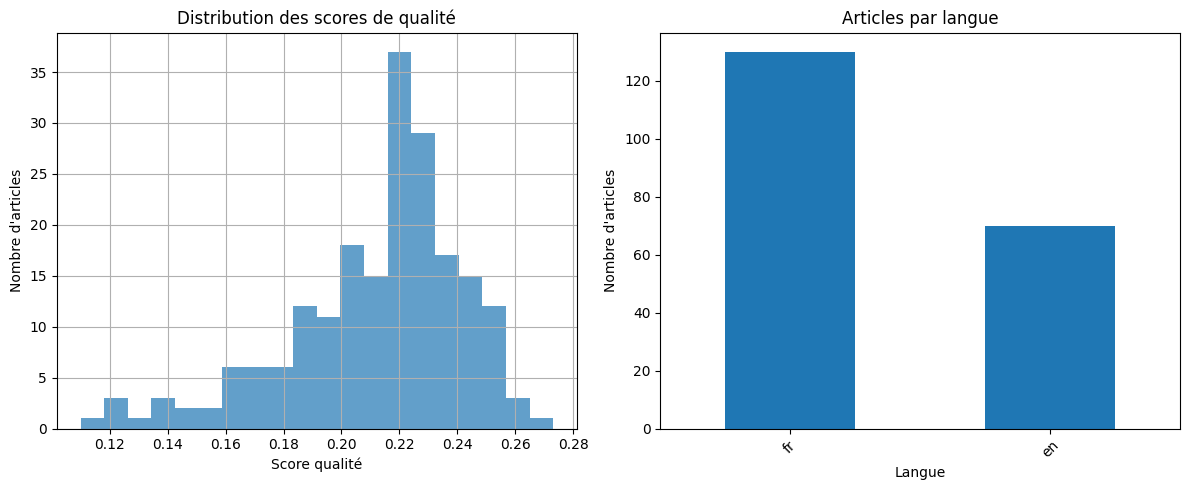

In [46]:
# ÉTAPE 6: ANALYSES ET VISUALISATIONS

# Conversion en DataFrame pour analyses
df = pd.DataFrame(enriched_articles)

# Analyse des enrichissements
if 'quality_score' in df.columns:
    quality_scores = df['quality_score'].dropna()
    print(f"Scores de qualité:")
    print(f"   Moyenne: {quality_scores.mean():.2f}")
    print(f"   Médiane: {quality_scores.median():.2f}")
    print(f"   Min: {quality_scores.min():.2f}")
    print(f"   Max: {quality_scores.max():.2f}")

if 'language' in df.columns:
    languages = df['language'].value_counts()
    print(f"\nLangues détectées:")
    for lang, count in languages.head().items():
        print(f"   {lang}: {count} articles")

# Graphiques simples
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Distribution des scores de qualité
if 'quality_score' in df.columns and df['quality_score'].notna().sum() > 0:
    df['quality_score'].hist(bins=20, ax=axes[0], alpha=0.7)
    axes[0].set_title('Distribution des scores de qualité')
    axes[0].set_xlabel('Score qualité')
    axes[0].set_ylabel('Nombre d\'articles')

# Répartition par langue
if 'language' in df.columns and df['language'].notna().sum() > 0:
    lang_counts = df['language'].value_counts().head(10)
    lang_counts.plot(kind='bar', ax=axes[1])
    axes[1].set_title('Articles par langue')
    axes[1].set_xlabel('Langue')
    axes[1].set_ylabel('Nombre d\'articles')
    axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()



In [47]:
#  ÉTAPE 7: RAPPORT FINAL


# Résumé du pipeline
total_pipeline_time = (datetime.now() - enrichment_stats["start_time"]).total_seconds()

print(f"RÉSUMÉ COMPLET:")
print(f"   Source: {latest_file.name}")
print(f"   Articles chargés: {len(raw_articles)}")
print(f"   Articles sélectionnés: {len(articles_to_enrich)}")
print(f"   Articles enrichis: {len(enriched_articles)}")
print(f"   Articles sauvés en BDD: {save_stats['saved']}")
print(f"   Temps total: {total_pipeline_time//60:.0f}m {total_pipeline_time%60:.0f}s")


RÉSUMÉ COMPLET:
   Source: raw_articles.json
   Articles chargés: 586
   Articles sélectionnés: 200
   Articles enrichis: 200
   Articles sauvés en BDD: 200
   Temps total: 2m 25s


In [48]:

print(f"\nTAUX DE SUCCÈS:")
total_input = len(raw_articles)
if total_input > 0:
    selection_rate = len(articles_to_enrich) / total_input * 100
    enrichment_success_rate = enrichment_stats["success"] / len(articles_to_enrich) * 100
    save_success_rate = save_stats["saved"] / len(enriched_articles) * 100
    
    print(f"   Sélection: {selection_rate:.1f}% ({len(articles_to_enrich)}/{total_input})")
    print(f"   Enrichissement: {enrichment_success_rate:.1f}% ({enrichment_stats['success']}/{len(articles_to_enrich)})")
    print(f"   Sauvegarde: {save_success_rate:.1f}% ({save_stats['saved']}/{len(enriched_articles)})")




TAUX DE SUCCÈS:
   Sélection: 34.1% (200/586)
   Enrichissement: 100.0% (200/200)
   Sauvegarde: 100.0% (200/200)


In [49]:
print(f"\nFICHIERS GÉNÉRÉS:")
print(f"   {enriched_file.name}")
print(f"   {light_file.name}")



# Nettoyage
session.close()


FICHIERS GÉNÉRÉS:
   enriched_articles.json
   enriched_light.json
